**Table of contents**<a id='toc0_'></a>    
- [Plots](#toc1_)    
- [SOM vs hotspells](#toc2_)    
  - [conditional probas](#toc2_1_)    
- [lagged time series](#toc3_)    
- [SOM vs Zoo](#toc4_)    
- [SOM vs T anomaly](#toc5_)    
  - [Intransivity](#toc5_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from definitions import *
from plots import *
from Experiment import *
from simpsom.plots import add_cluster
from sklearn.cluster import DBSCAN, KMeans

%load_ext autoreload
%autoreload 2

In [11]:
exp_som = ClusteringExperiment(
    'ERA5', 'Wind', '300', None, None, -60, 60, 20, 80, 
    'anomaly', 'JJA', 'doy', {'dayofyear': ('win', 90)}, 
    {'detrended': False, 'time': ('fft', 10)}, inner_norm=0
)

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 63 times more chunks
  return self.array[key]
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute

In [13]:
X, da = exp_som.prepare_for_clustering()

In [14]:
X

array([[ 2.30386644,  2.90722963,  3.41357599, ..., -2.5979352 ,
        -2.55025173, -2.51208671],
       [ 2.28884679,  2.87127276,  3.40204824, ..., -1.60032188,
        -1.53209038, -1.47632126],
       [ 2.7887564 ,  3.29971015,  3.80594926, ..., -0.66536339,
        -0.59325483, -0.53320113],
       ...,
       [ 4.59741179,  4.58687255,  4.54385577, ..., -0.81556594,
        -0.86712402, -0.88507427],
       [ 4.70669703,  4.70828907,  4.73036136, ..., -1.18705826,
        -1.20837385, -1.20675224],
       [ 4.41279074,  4.50895098,  4.66438961, ..., -1.90019123,
        -1.8843928 , -1.85703681]])

In [26]:
net, centers = exp_som.compute_som(8, 8, 150, False, False, True, inner_dist_type='grid', train_kwargs=dict(train_algo='batch', epochs=500))
da_som = exp_som.open_da('anomaly', 'JJA')
indices = net.bmus
coords = net.neighborhoods.coordinates


2023-05-31 15:56:27.220 | INFO     | simpsom.network:__init__:116 - Periodic Boundary Conditions active.
2023-05-31 15:56:27.224 | INFO     | simpsom.network:__init__:127 - Hexagonal topology.
2023-05-31 15:56:27.226 | WARNING  | simpsom.network:_set_weights:197 - Please be sure that the data have been standardized before using PCA.
2023-05-31 15:56:27.227 | INFO     | simpsom.network:_set_weights:200 - The weights will be initialized with PCA.
2023-05-31 15:56:27.246 | INFO     | simpsom.network:train:362 - The map will be trained with the batch algorithm.
100%|██████████| 500/500 [01:33<00:00,  5.35it/s]
2023-05-31 15:58:00.907 | INFO     | simpsom.network:save_map:285 - Map shape and weights will be saved to:
/storage/scratch/users/hb22g102/ERA5/Wind/300/box_-60_60_20_80/doy_doywin90/timefft10/som_8_8_150_anomaly_JJA_0.npy
2023-05-31 15:58:09.988 | INFO     | simpsom.network:project_onto_map:556 - Projected coordinates will be saved to:
././som_projected.npy


In [27]:
X, da = exp_som.prepare_for_clustering()
X1 = exp_som.opp_transform(net.weights, 150, 10, 1)
X2 = exp_som.opp_transform(net.weights, 150, 10, 2)
clu_labs = cluster_from_projs(X1, cutoff=3)

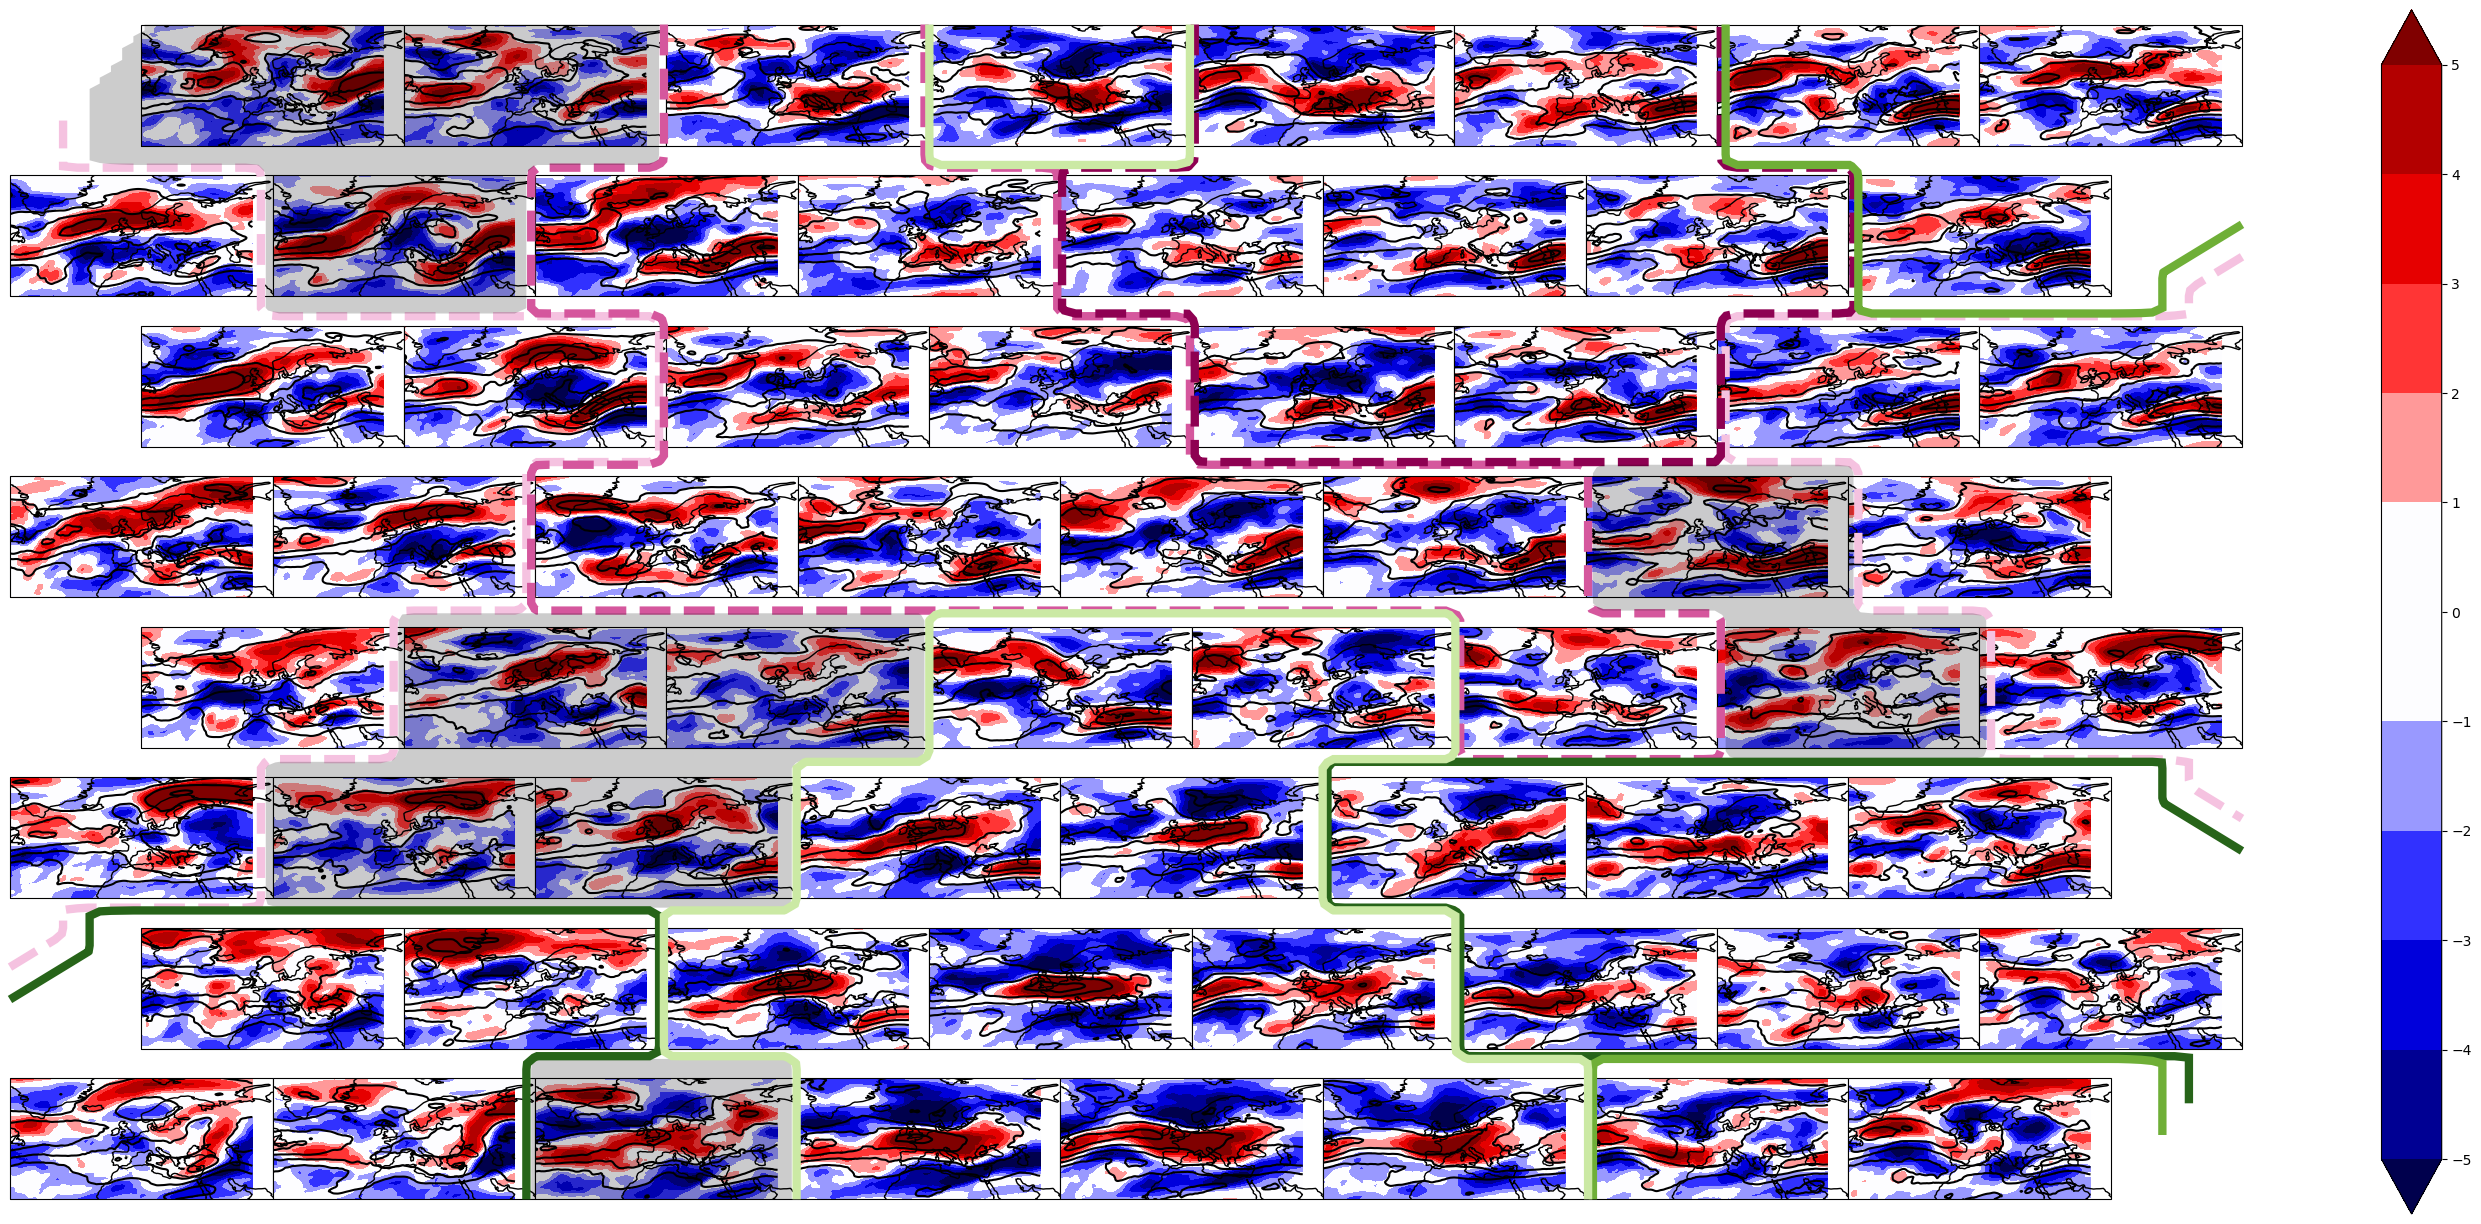

In [28]:
mask = (indices[:, None] == np.arange(net.n_nodes)[None, :])
clu = Clusterplot(net.width, net.height, honeycomb=True)
clu.add_any_contour_from_mask(da_som, mask, type='contourf')
clu.add_any_contour_from_mask(exp_som.open_da(season='JJA'), mask, nlevels=6, type='contour')
clu.cluster_on_fig(coords, clu_labs)

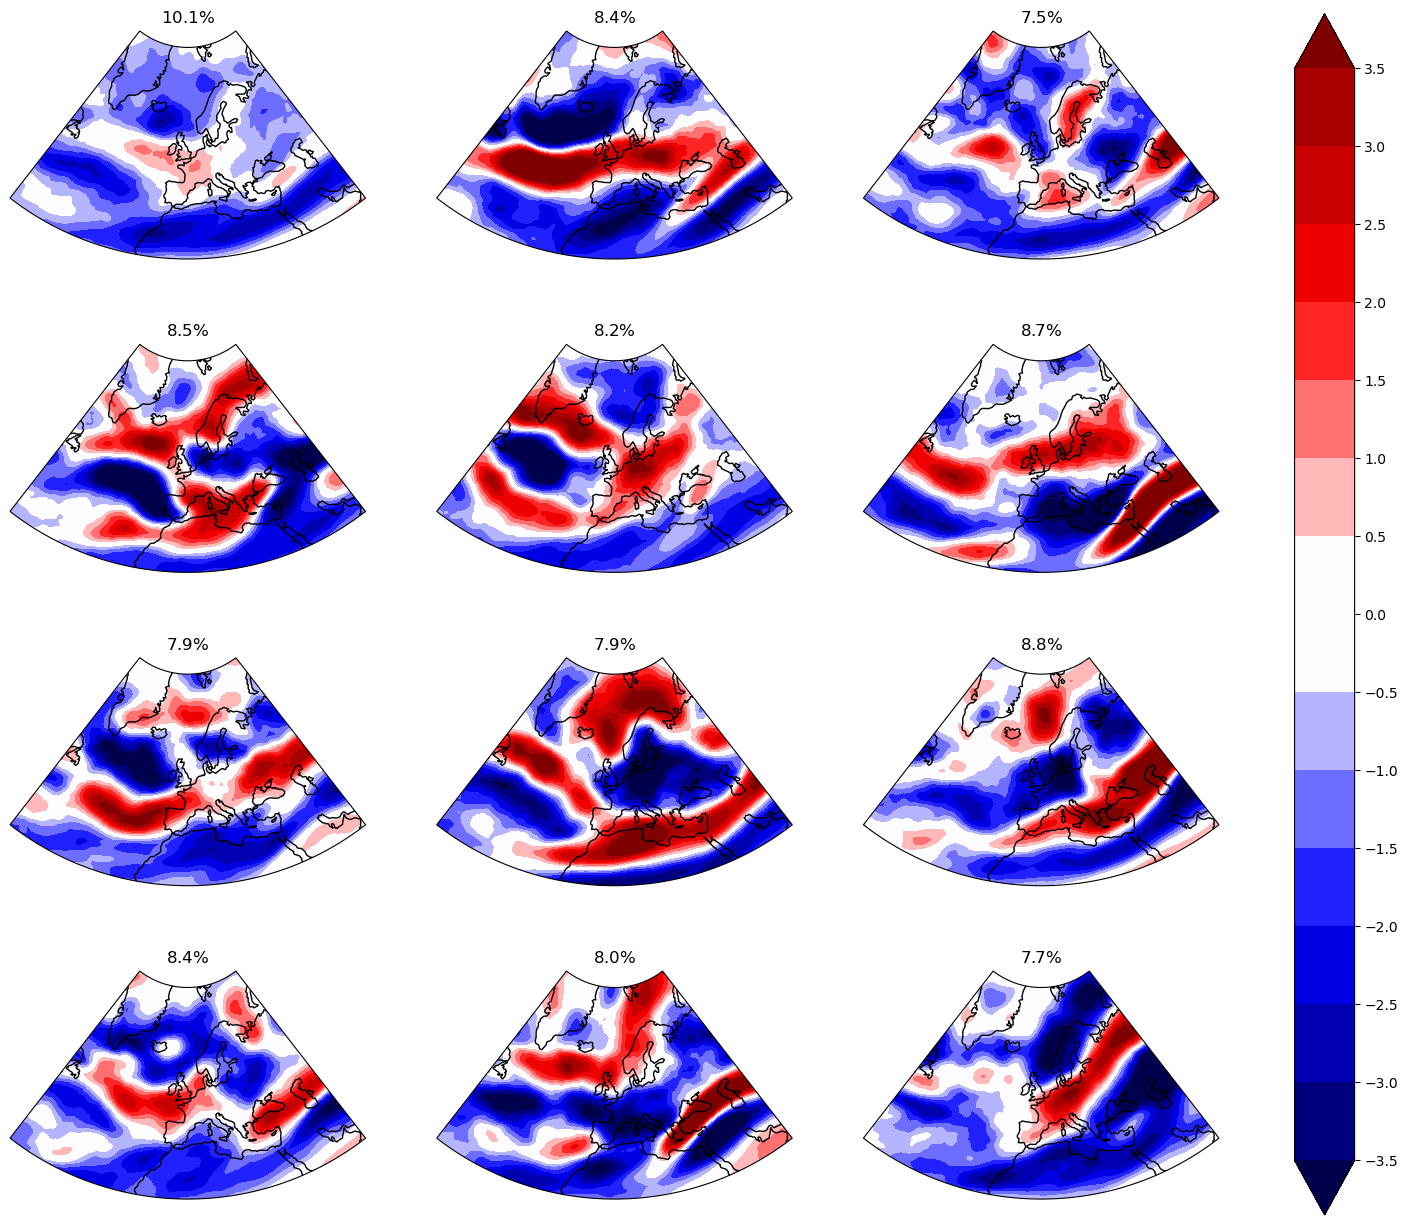

In [32]:
# centers, path = exp_som.cluster(11, 150, return_centers='project')
clu = Clusterplot(4, 3, lambert_projection=True, region=(-60, 60, 20, 80))
titles = [f'${ratio * 100:.1f}\%$' for ratio in centers.ratios.values]
clu.add_contourf(centers, titles=titles)

In [61]:
exp_T = Experiment(exp_som.dataset, 'Temperature', '2m', 'box_-25_60_32_72', 't')
da_T = exp_T.open_da('anomaly', 'JJA')

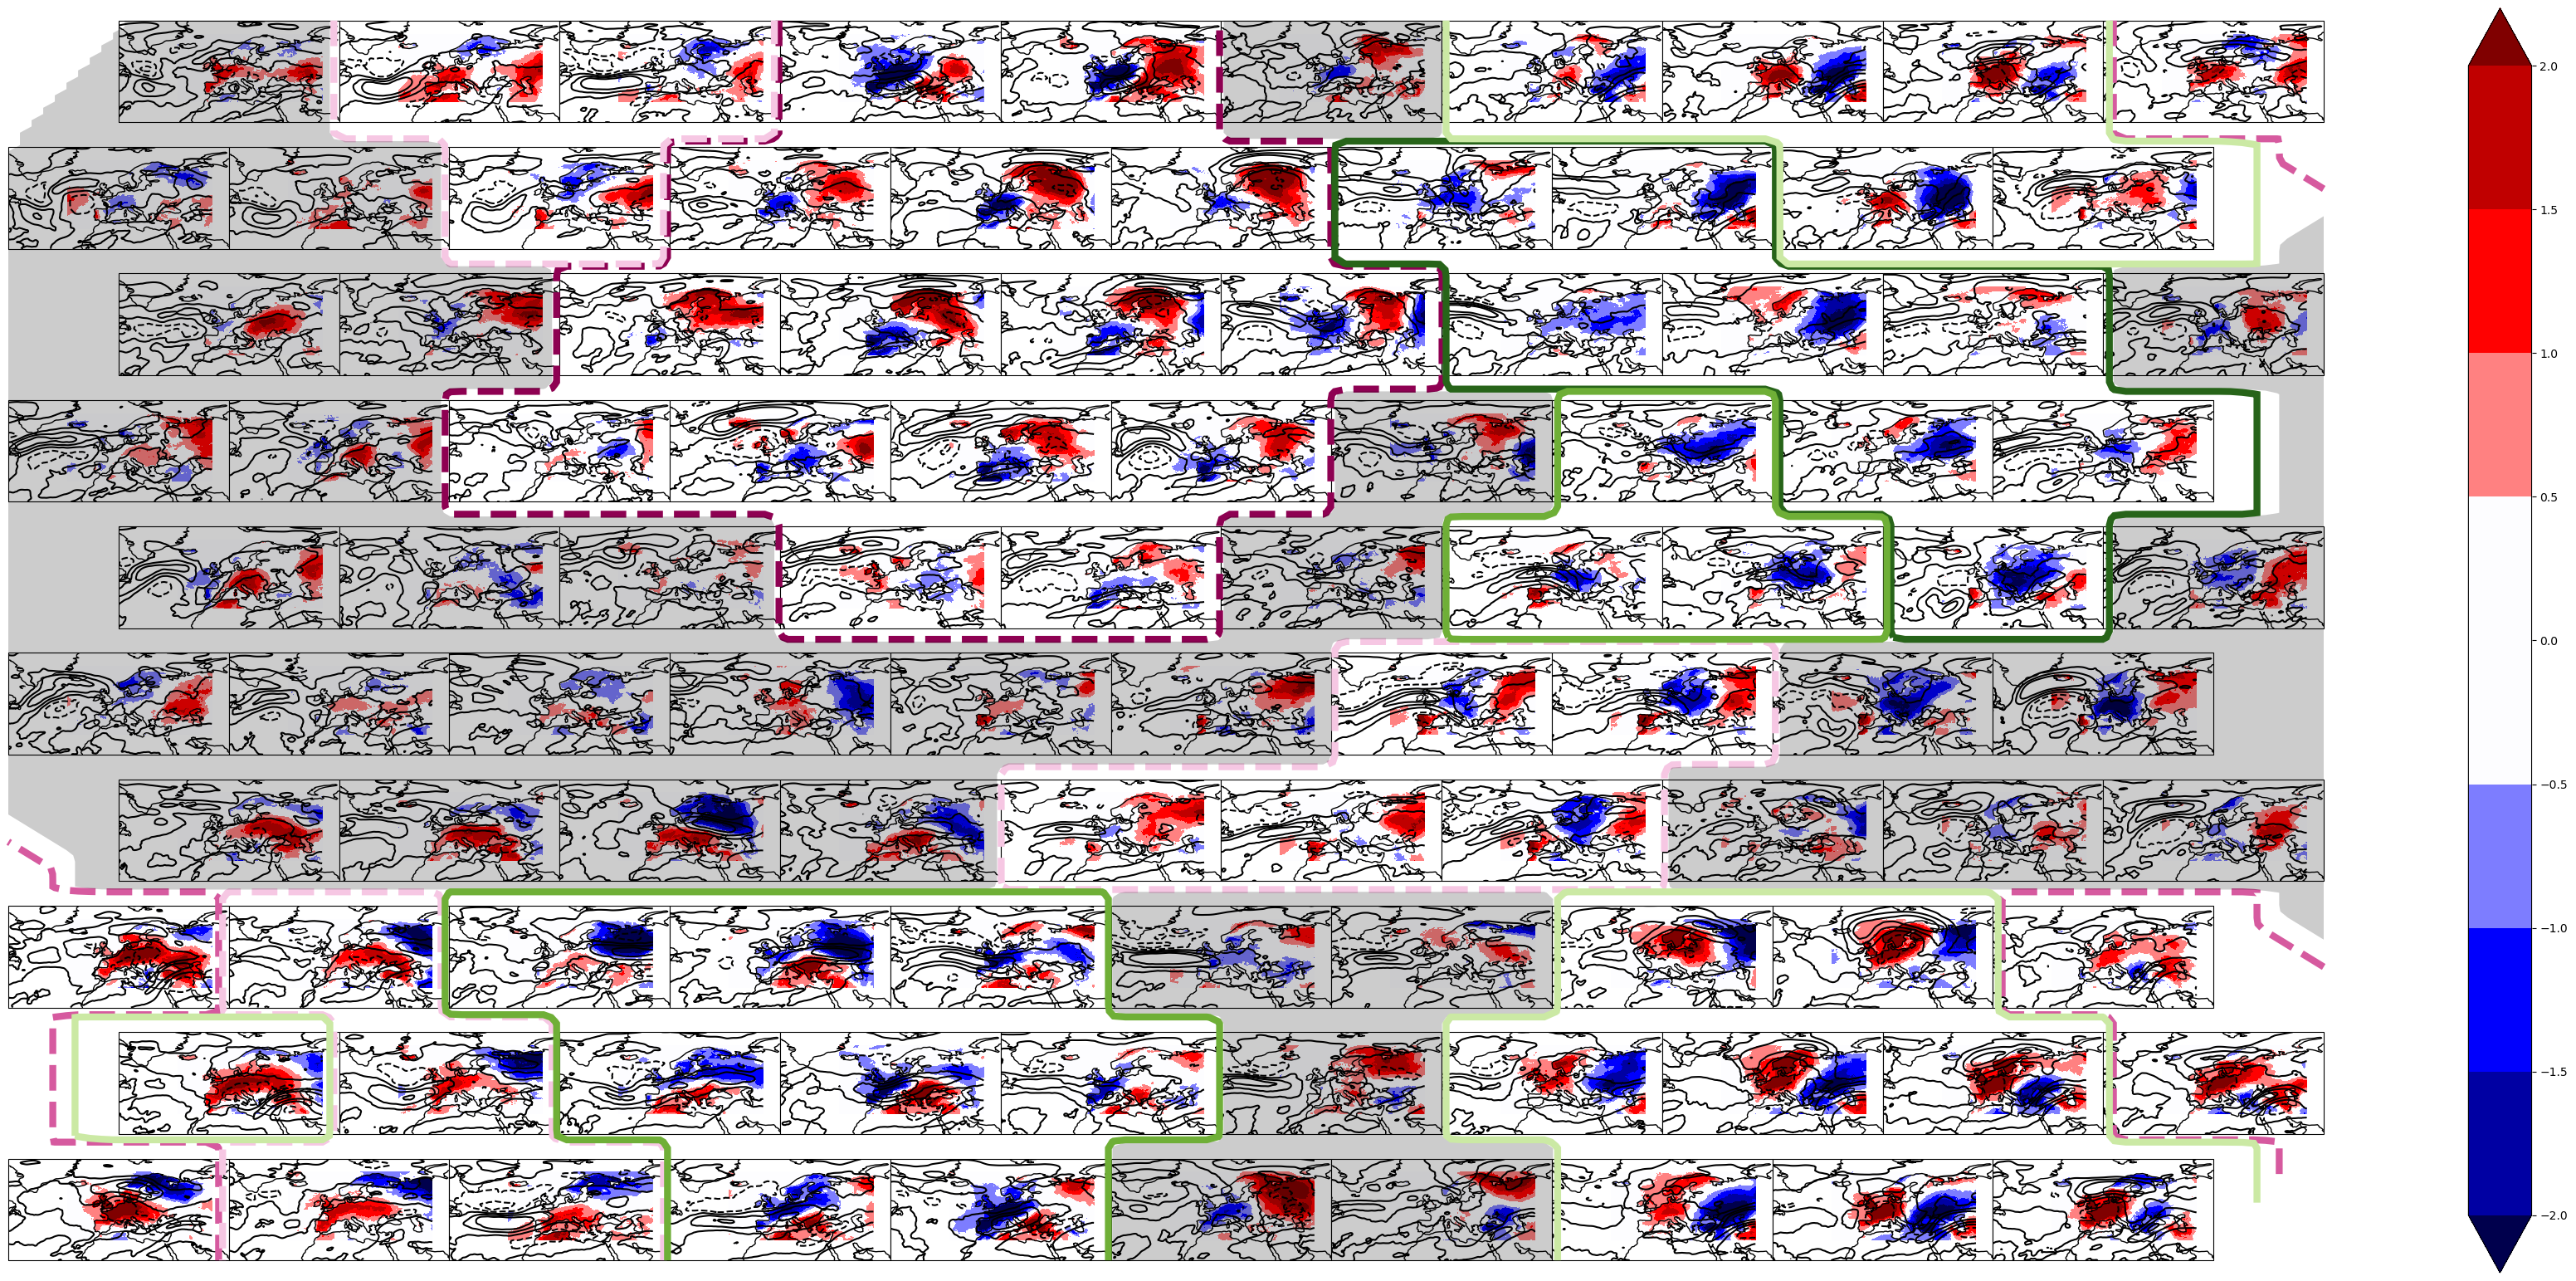

In [62]:
mask = (indices[:, None] == np.arange(net.n_nodes)[None, :])
clu = Clusterplot(net.width, net.height, honeycomb=True)
clu.add_any_contour_from_mask(da_som, mask, type='contour', nlevels=3, linestyles=['dashed', 'solid'])
clu.add_any_contour_from_mask(da_T, mask)
clu.cluster_on_fig(coords, clu_labs)

# <a id='toc1_'></a>[Plots](#toc0_)

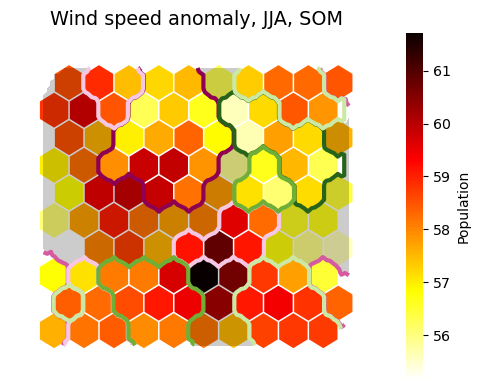

In [71]:
cmap = mpl.colormaps["hot"].reversed()
populations = net.compute_populations()
kwargs = {
    "cmap": cmap,
    "cbar_label": f"Population",
    "title": "Wind speed anomaly, JJA, SOM",
}
fig, ax = net.plot_on_map(
    populations,
    smooth_sigma=1,
    show=False,
    **kwargs
)
fig, ax = add_cluster(
    fig, ax, coords, clu_labs
)

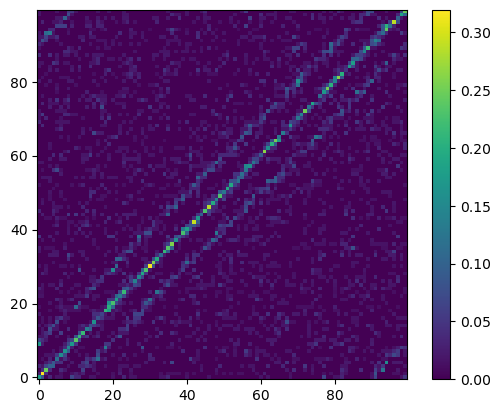

In [74]:
trans_mat = net.compute_transmat(step=1)
fig, ax = plt.subplots()
im = ax.imshow(trans_mat, origin="lower")
fig.colorbar(im, ax=ax)


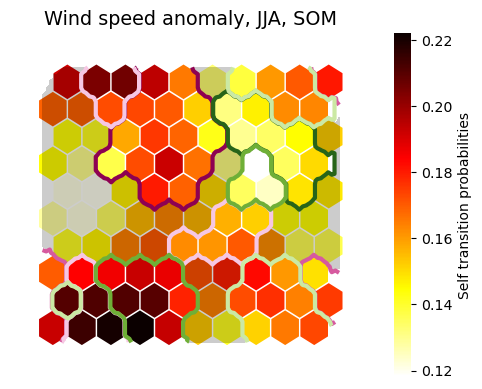

In [75]:
cmap = mpl.colormaps["hot"].reversed()
kwargs = {
    "cmap": cmap,
    "cbar_label": f"Self transition probabilities",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    np.diag(trans_mat),
    smooth_sigma=1,
    show=False,
    **kwargs
)
fig, ax = add_cluster(
    fig, ax, coords, clu_labs
)

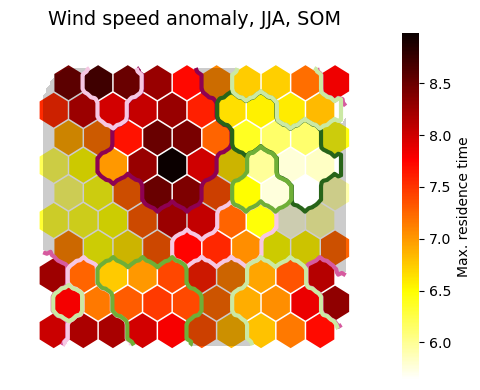

In [73]:
rt_max = net.compute_residence_time('max', smooth_sigma=1)

kwargs = {
    "cmap": cmap,
    "cbar_label": f"Max. residence time",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    rt_max,
    smooth_sigma=1,
    show=False,
    **kwargs
)
fig, ax = add_cluster(
    fig, ax, coords, clu_labs
)

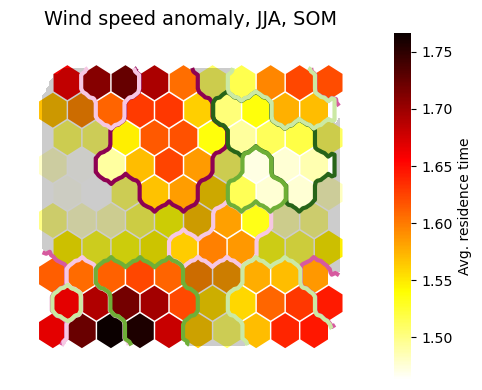

In [76]:
rt_max = net.compute_residence_time('mean', smooth_sigma=1)

kwargs = {
    "cmap": cmap,
    "cbar_label": f"Avg. residence time",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    rt_max,
    smooth_sigma=1,
    show=False,
    **kwargs
)
fig, ax = add_cluster(
    fig, ax, coords, clu_labs
)

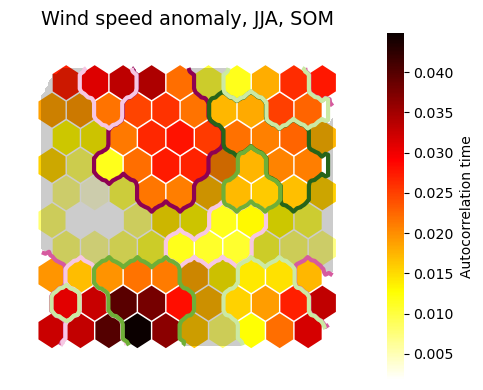

In [77]:
acorr = net.compute_autocorrelation(lag_max=30)

kwargs = {
    "cmap": cmap,
    "cbar_label": f"Autocorrelation time",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    acorr[3, :],
    smooth_sigma=1,
    show=False,
    **kwargs
)
fig, ax = add_cluster(
    fig, ax, coords, clu_labs
)

# <a id='toc2_'></a>[SOM vs hotspells](#toc0_)

## <a id='toc2_1_'></a>[conditional probas](#toc0_)

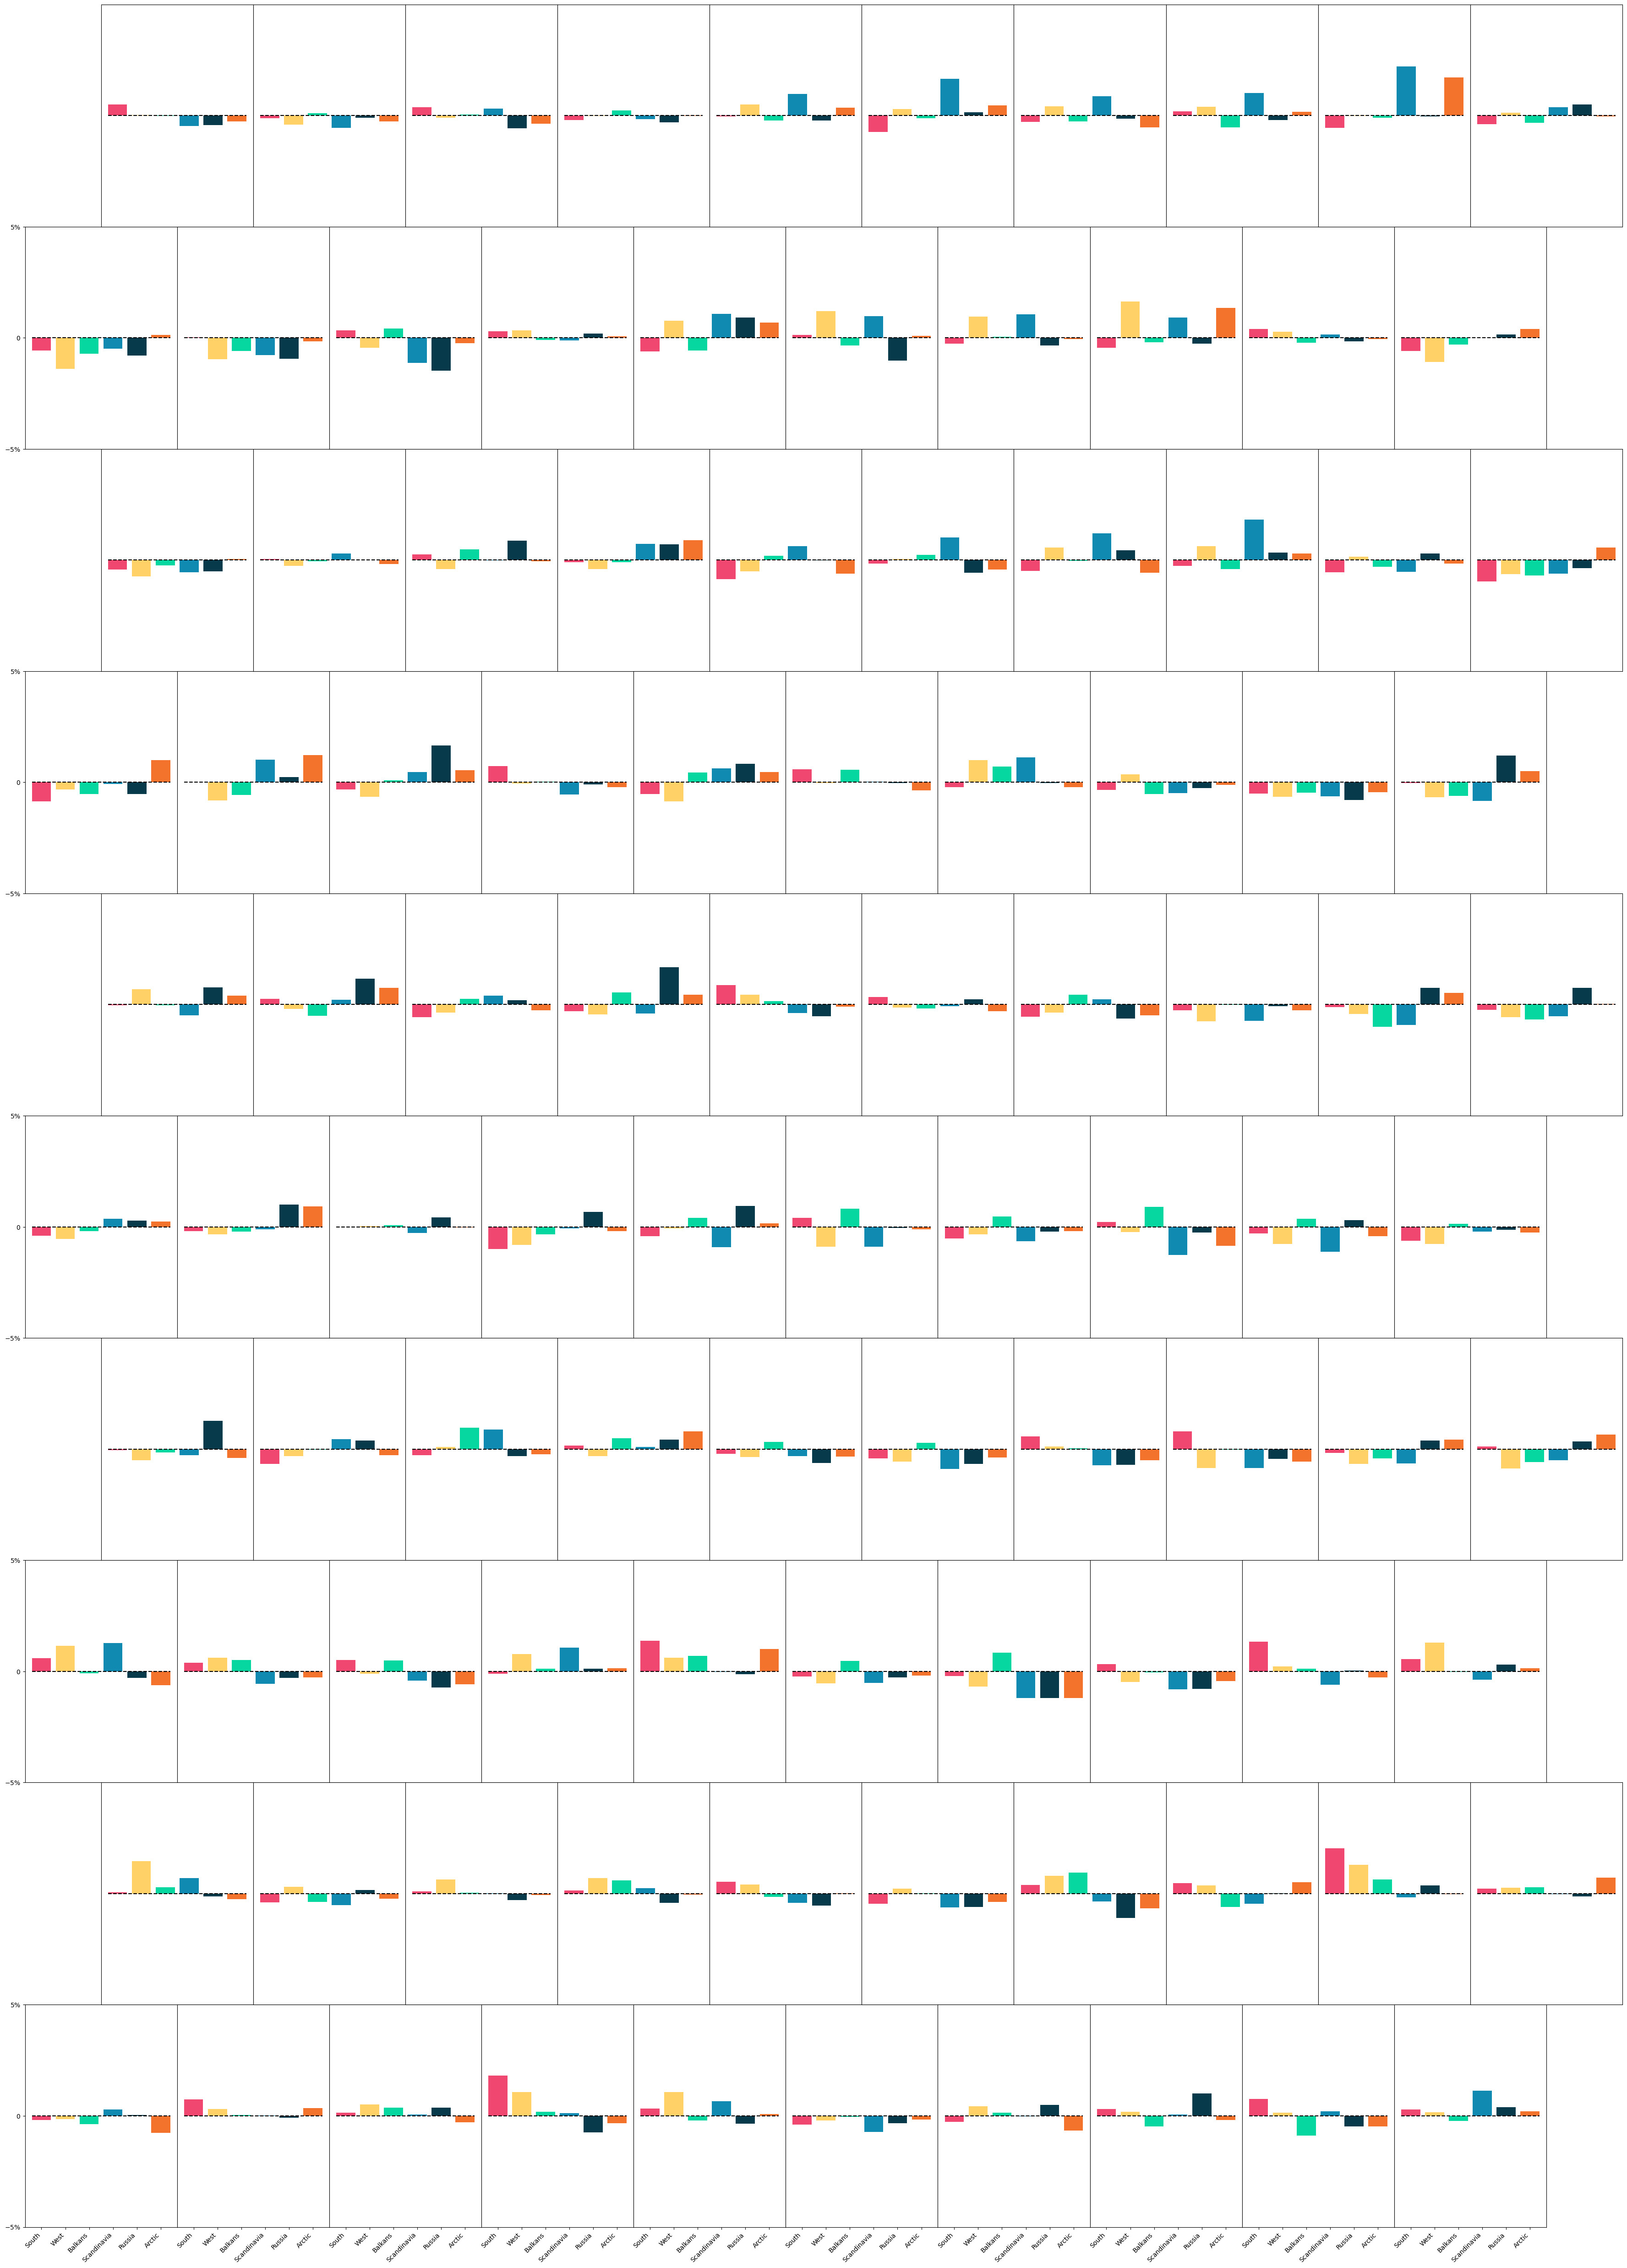

In [35]:
lag = 1
probas = np.sum(np.roll(node_mask[lag:, :, None], shift=lag, axis=0) & hs_mask.values[lag:, None, :], axis=0) / np.sum(hs_mask.values, axis=0)[None, :]
probas -= populations[:, None] / np.sum(populations)
fig, axes = honeycomb_panel(net.width, net.height)
for ax, proba in zip(axes.flatten(), probas):
    ax.bar(np.arange(6), proba, color=COLORS5)
    ax.plot([- 0.4, 5.4], [0, 0], color='black', ls='dashed', zorder=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim([-0.05, 0.05])
for ax in axes[0, ::2]:
    ax.set_yticks([-0.05, 0., 0.05], [r'$-5\%$', r'$0$', r'$5\%$'])
for ax in axes[:, 0]:
    ax.set_xticks(np.arange(6), REGIONS, rotation=45, ha='right')

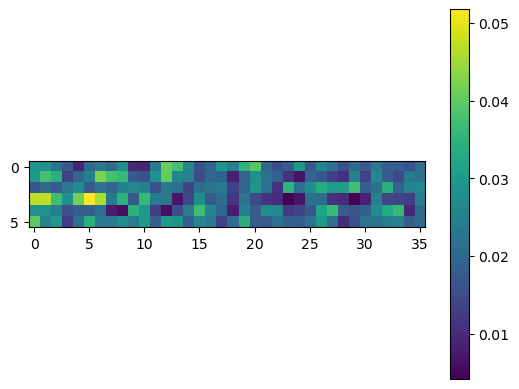

In [14]:
im = plt.imshow(np.sum(hs_mask.values[:, :, None] & node_mask[:, None, :], axis=0) / np.sum(hs_mask.values[:, :, None] | node_mask[:, None, :], axis=0))
plt.colorbar(im)

# <a id='toc3_'></a>[lagged time series](#toc0_)

In [15]:
hotspells, maxnhs, maxlen = get_hostpells_v2()
node_mask_da_hs = apply_hotspells_mask_v2(hotspells, node_mask_da, maxlen, maxnhs)

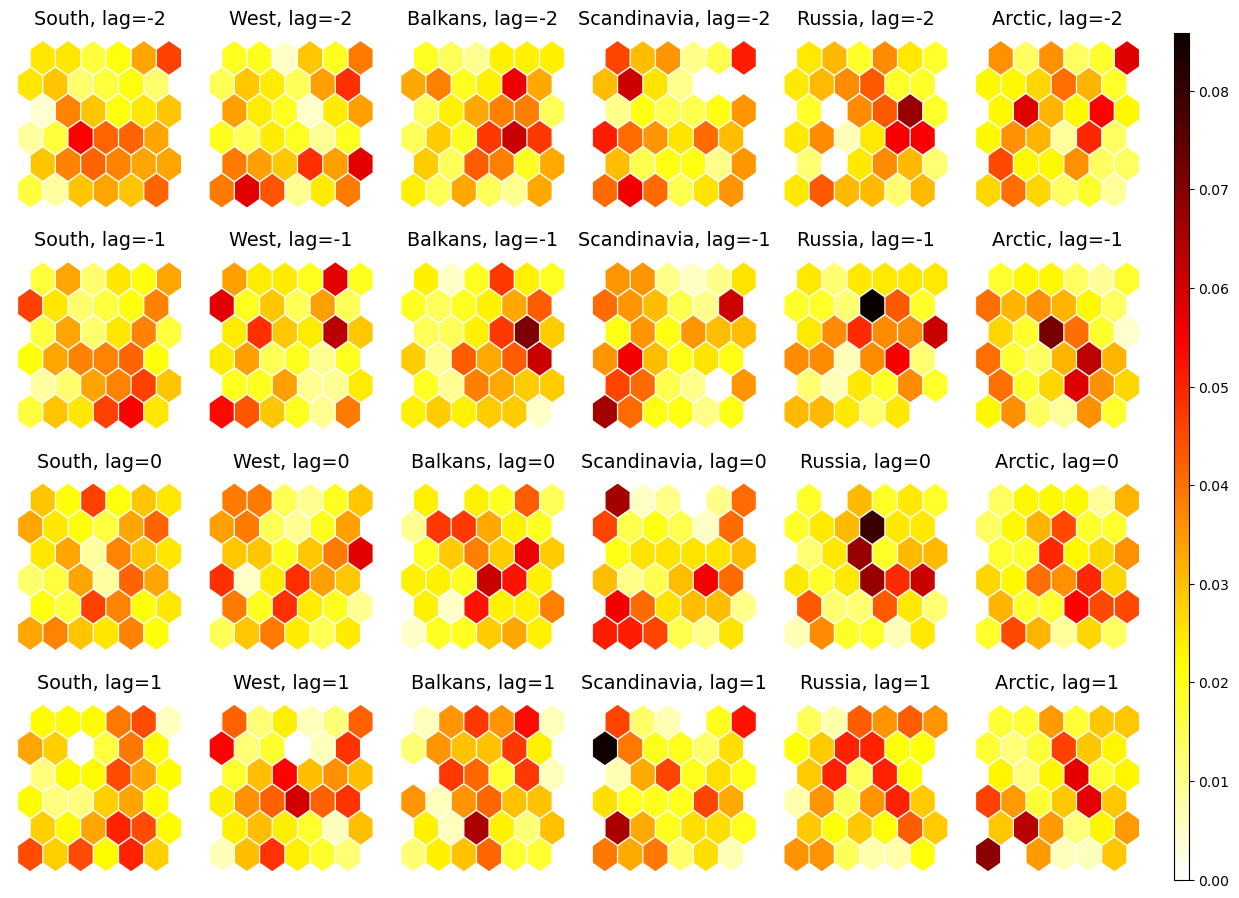

In [16]:
lags = [-2, -1, 0, 1]
to_plot = node_mask_da_hs.sel(day_after_beg=lags).mean(dim='hotspell')
kwargs = {
    "cmap": mpl.colormaps["hot"].reversed(),
    "norm": Normalize(vmin=0, vmax=to_plot.max())
}
im = ScalarMappable(kwargs['norm'], kwargs['cmap'])
fig, axes = plt.subplots(len(lags), len(REGIONS), figsize=(14, 9))
for ilag, lag in enumerate(lags):
    for ax, region in zip(axes[ilag], REGIONS):
        kwargs['title'] = f'{region}, {lag=}'
        fig, ax = net.plot_on_map(
            to_plot.sel(region=region, day_after_beg=lag),
            smooth_sigma=0,
            fig=fig,
            ax=ax,
            show=False,
            draw_cbar=False,
            **kwargs
        )
fig.colorbar(im, ax=axes, shrink=1.0, pad=0.02, aspect=60)
plt.show()

# <a id='toc4_'></a>[SOM vs Zoo](#toc0_)

In [36]:
varnames = ['Lat', 'Int', 'Tilt', 'Dep', 'Mea']
Zoo = xr.open_dataset(f'{DATADIR}/ERA5/Wind/Low/box_-80_40_20_80/Zoo.nc')
Zoo = Zoo[varnames].isel(time=Zoo.time.dt.season=='JJA')
mu = Zoo.mean(dim='time')
sigma = Zoo.std(dim='time', ddof=1)
node_mask = indices[:, None] == np.arange(net.n_nodes)[None, :]
node_mask_da = xr.DataArray(node_mask, coords={'time': Zoo.time, 'node': np.arange(net.n_nodes)})

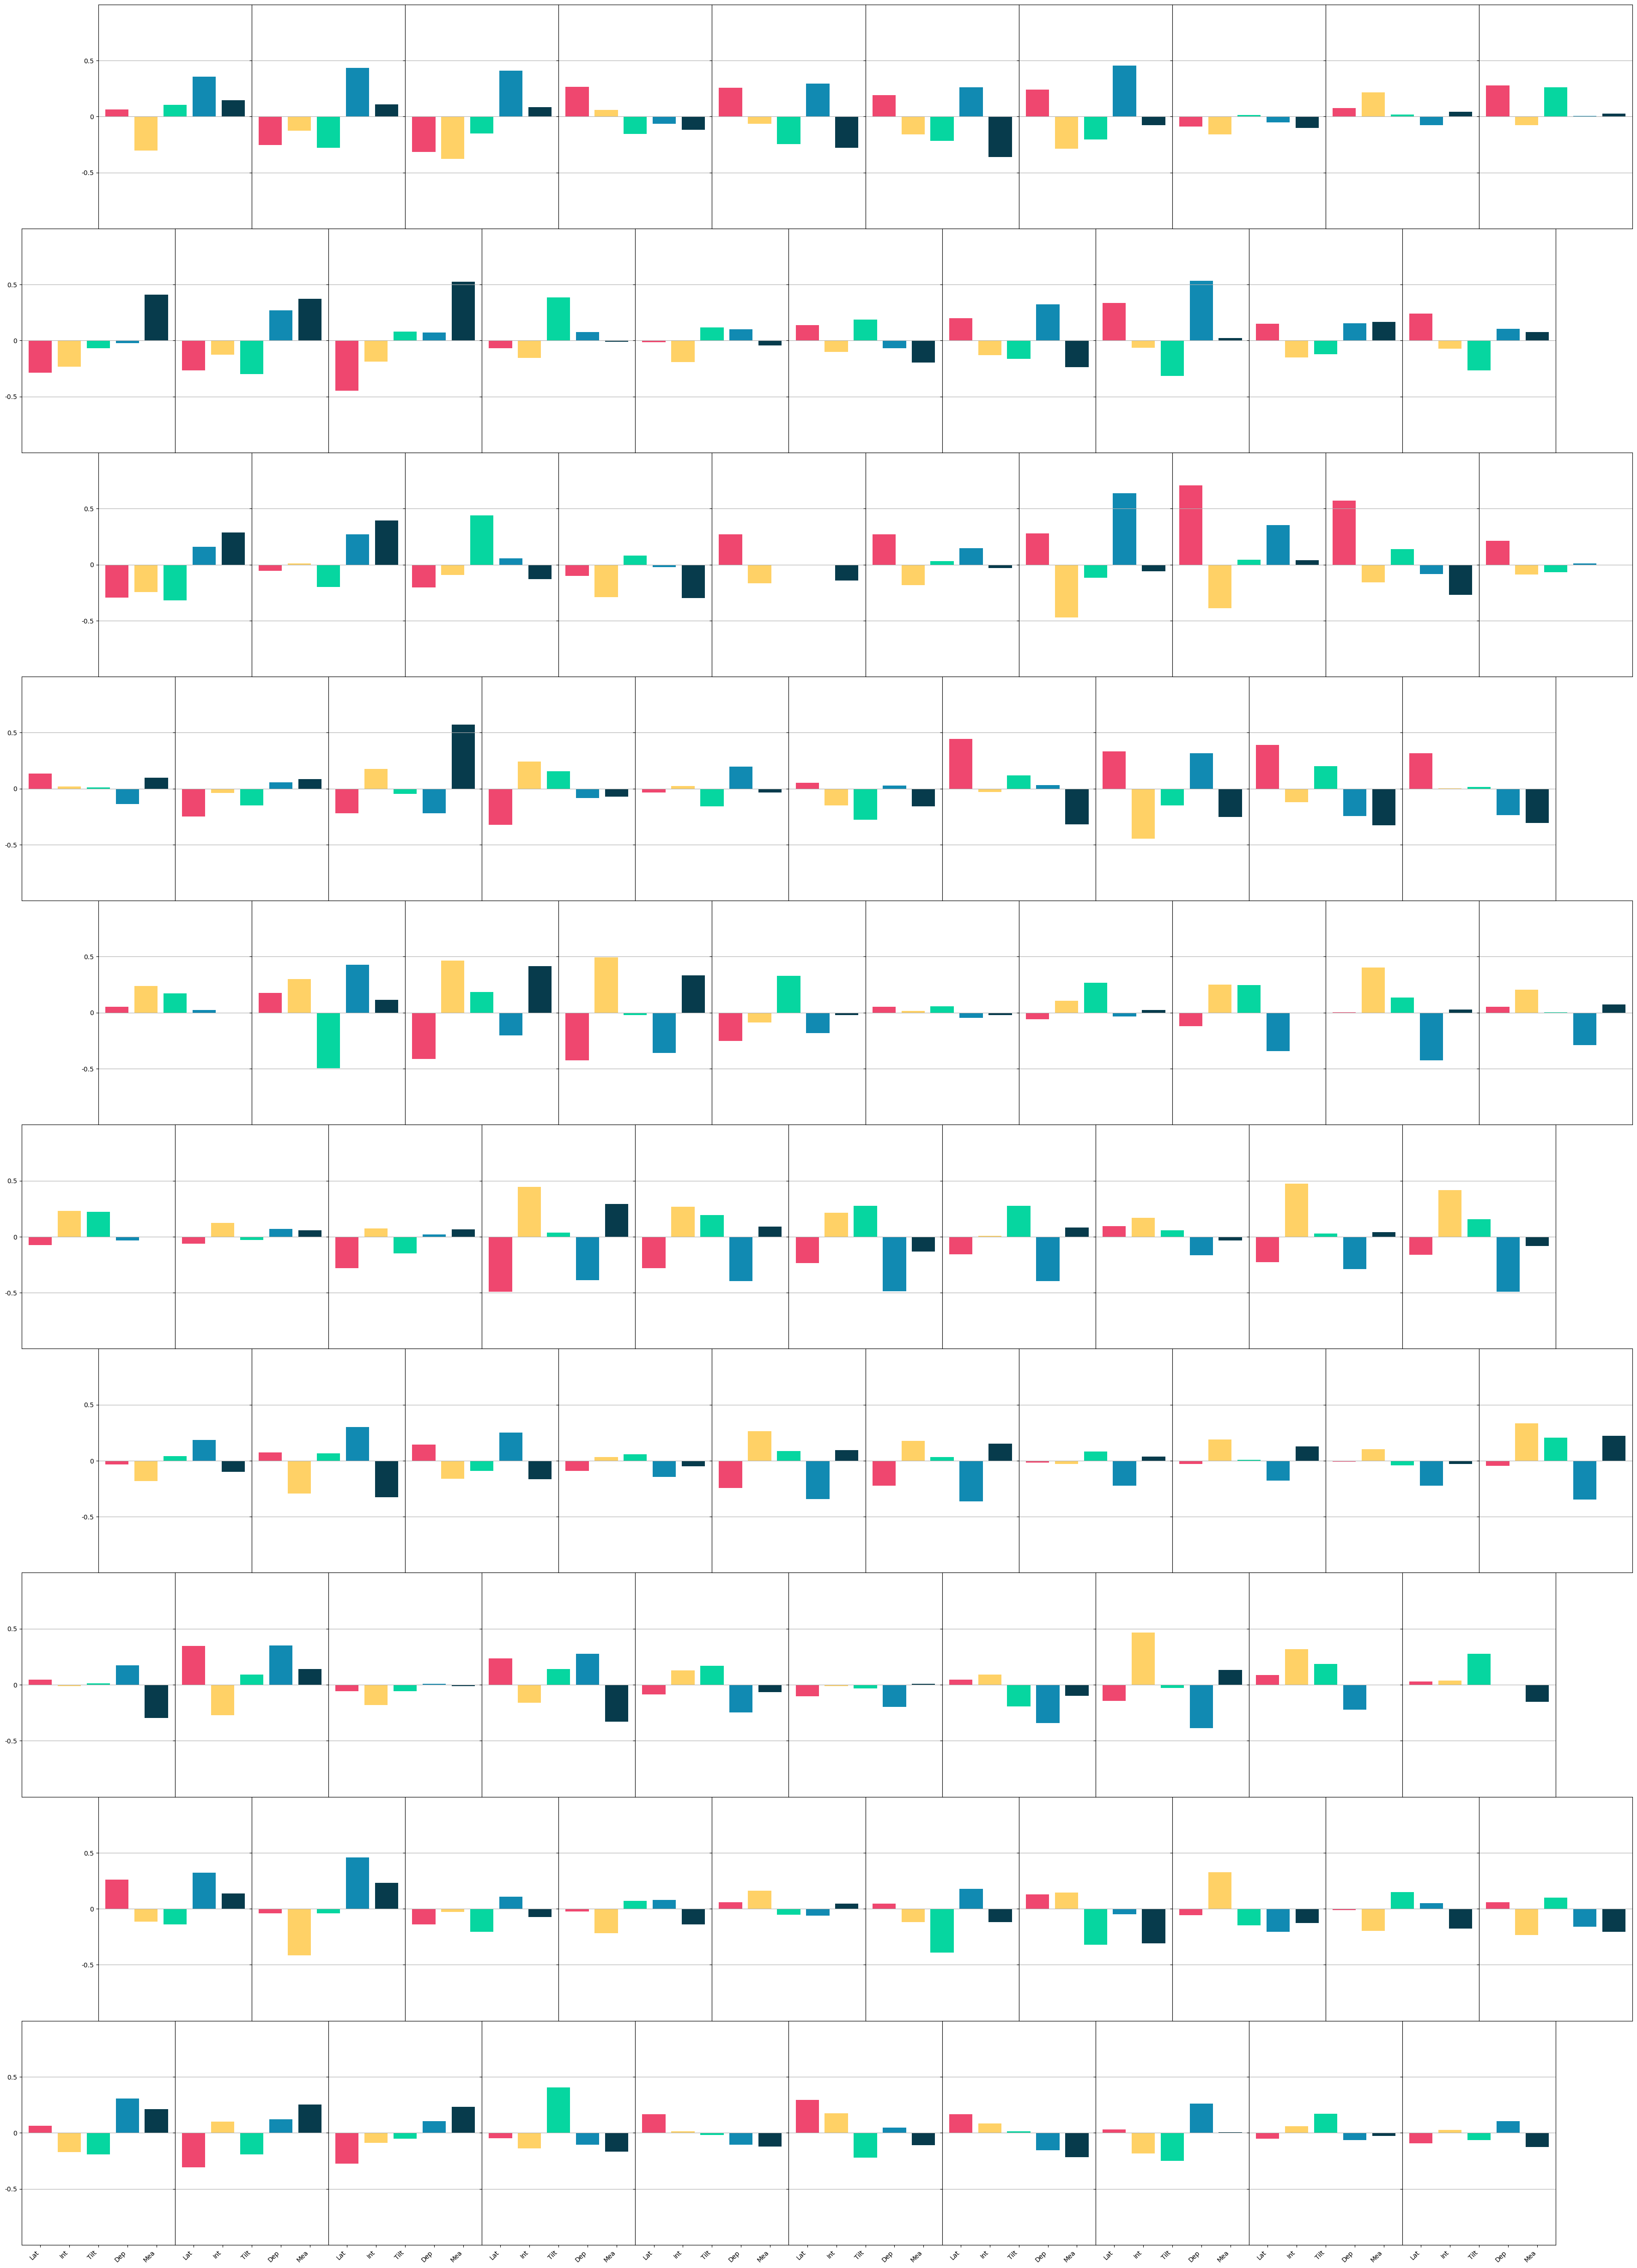

In [37]:
fig, axes = honeycomb_panel(net.width, net.height)
for ax, mask in zip(axes.flatten(), node_mask.T):
    thismu = Zoo.isel(time=mask).mean(dim='time')
    to_plot = [(thismu[vn] - mu[vn]) / sigma[vn] for vn in varnames]
    ax.bar(np.arange(len(varnames)), to_plot, color=COLORS5, label=varnames)
    ax.set_ylim([-1, 1])
    ax.set_xticks([])
    ax.set_yticks([-0.5, 0, 0.5], [''] * 3)
    ax.grid(True, axis='y')
for ax in axes[0, :]:
    ax.set_yticks([-0.5, 0, 0.5], [-0.5, 0, 0.5])
for ax in axes[:, 0]:
    ax.set_xticks(np.arange(5), varnames, rotation=45, ha='right')

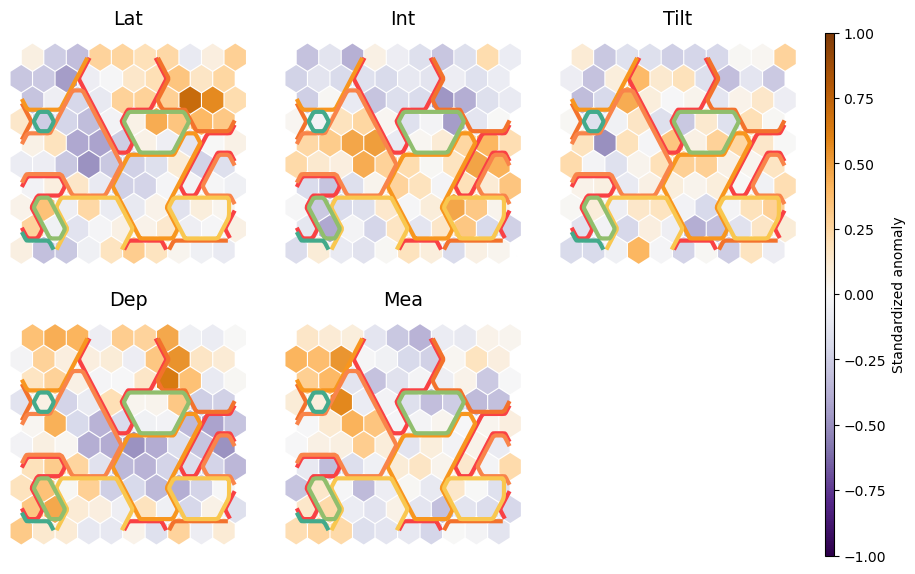

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
mean_on_node = xr.concat([Zoo.isel(time=mask).mean(dim='time') for mask in node_mask.T], dim='node')
axes = axes.flatten()
kwargs = {
    "cmap": mpl.colormaps["PuOr"].reversed(),
    "norm": Normalize(vmin=-1, vmax=1),
}
im = ScalarMappable(kwargs['norm'], kwargs['cmap'])
for ax, varname in zip(axes[:-1], varnames):
    kwargs['title'] = varname
    thismu = Zoo[varname].mean(dim='time')
    to_plot = (mean_on_node[varname] - mu[varname]) / sigma[varname]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        fig=fig,
        ax=ax,
        show=False,
        draw_cbar=False,
        **kwargs
    )
    fig, ax = add_cluster(
        fig, ax, coords, maxproj_T2, COLORS10
    )
axes[-1].set_visible(False)
fig.colorbar(im, ax=axes, shrink=1.0, pad=0.03, aspect=60, label='Standardized anomaly')
plt.show()

# <a id='toc5_'></a>[SOM vs T anomaly](#toc0_)

In [4]:
exp_T = Experiment(exp_som.dataset, 'Temperature', '2m', 'box_-25_60_32_72', 't')
da_T = exp_T.open_da('anomaly', 'JJA')
# da_T = da_T.drop_duplicates(dim='time').interp(time=da_som.time)
Zoo = xr.open_dataset(f'{DATADIR}/ERA5/Wind/Low/box_-80_40_20_80/Zoo.nc')
da_s = exp_som.open_da('anomaly', 'JJA')


In [5]:
multimask = (indices[:, None] == np.arange(net.n_nodes)[None, :]).reshape(-1, net.width, net.height)

In [ ]:
coords = {
    'x': centers['x'],
    'y': centers['y'],
    'lat': da_T['lat'],
    'lon': da_T['lon']
}
center_temps = xr.DataArray(np.empty((net.width, net.height, *da_T.shape[1:])), coords=coords)
for i, j in product(range(net.width), range(net.height)):
    center_temps[i, j] = da_T.isel(time=multimask[:, i, j]).mean(dim='time')
clu = Clusterplot(net.width, net.height, honeycomb=True)
to_plot = [centers.sel(x=i, y=j) for j in range(net.width) for i in range(net.height)]
clu.add_contour(to_plot, nlevels=3, linestyles=['dashed', 'solid'])
titles = [f'$T_1$ OPP={mpt1}, $T_2$ OPP={mpt2}' for mpt1, mpt2 in zip(maxproj_T1, maxproj_T2)]
clu.add_contourf([center_temps[i, j] for j in range(net.width) for i in range(net.height)],titles=titles)

## <a id='toc5_1_'></a>[Intransivity](#toc0_)

In [84]:
allnodes = np.arange(net.n_nodes)
indices_mask = indices[:, None] == allnodes[None, :]
indices_mask = xr.DataArray(indices_mask, coords={'time': da_som.time.values, 'node': allnodes})

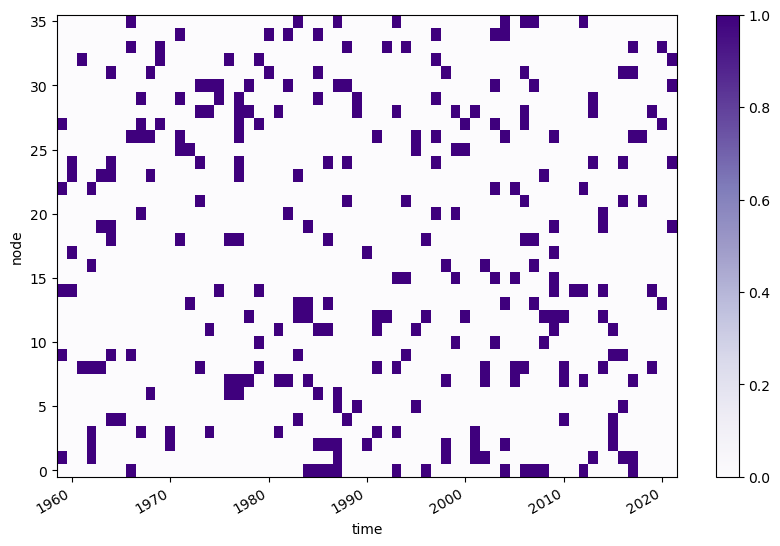

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = LinearSegmentedColormap.from_list(
    "gr",
    [
        [21 / 256, 176 / 256, 26 / 256, 1],
        [1, 1, 1, 1],
        [229 / 256, 0, 0, 1],
    ],
    N=50,
)
to_plot = indices_mask.resample(time='1YS').any(dim='time').T
(~to_plot).plot.pcolormesh(cmap='Purples') #, linewidth=.5, edgecolors='white')
